In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pylab as plt
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
from pgmpy.models import BayesianNetwork
from pgmpy.sampling import BayesianModelSampling

Consider the following DAG, $\mathcal{G}$, depicting a belief network on $n = 10$ random variable nodes $X_1, \ldots, X_{10}$.

In [2]:
# Define G
model = BayesianNetwork([('X_1', 'X_5'), ('X_2', 'X_5'), ('X_2', 'X_6'),
                         ('X_3', 'X_6'), ('X_3', 'X_7'), ('X_4', 'X_7'),
                         ('X_5', 'X_8'), ('X_6', 'X_8'), ('X_6', 'X_9'),
                         ('X_7', 'X_9'), ('X_8', 'X_10'), ('X_9', 'X_10')])

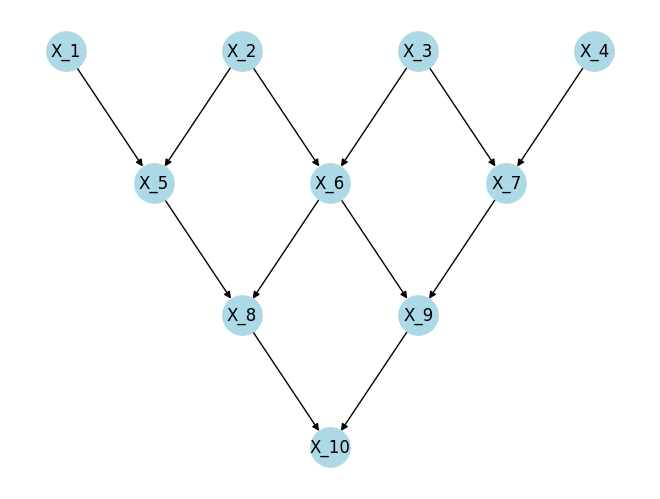

In [3]:
# Plot the graph
pos = {
    'X_1': (1, 4),
    'X_2': (3, 4),
    'X_3': (5, 4),
    'X_4': (7, 4),
    'X_5': (2, 3),
    'X_6': (4, 3),
    'X_7': (6, 3),
    'X_8': (3, 2),
    'X_9': (5, 2),
    'X_10': (4, 1)
}
nx.draw(model, with_labels=True, node_size = 800, node_color = 'lightblue', pos=pos)
plt.show()

Let $P_i = \text{parents}_\mathcal{G}(X_i)$ denote the parents of node $X_i$ in the graph $\mathcal{G}$, and let $\zeta_i = \sum_{j: X_j \in P_i} X_j$ denote the sum of values taken by the parent nodes of $X_i$. The joint probability distribution $\mathbb{P}_\mathcal{G}(X_1, \ldots, X_n)$ for the belief network is specified by the following conditional probability distributions for individual nodes:

$$
X_i \mid P_i \sim \begin{cases} 
\text{Uniform}\{0, 1, \ldots, 10\} & \text{if } P_i = \emptyset \\
\text{Uniform}\{0, \ldots, \zeta_i\} & \text{if } P_i \neq \emptyset.
\end{cases}
$$

I will implement the conditional probabilities and use the code to evaluate $\mathbb{P}(X_3 = 1 \mid X_7 = 1)$.

In [4]:
# Define the CPDs

# Use the distribution in Equation 2
values_1_2_3_4 = [[1/11]]*11
cpd_1 = TabularCPD(variable='X_1', variable_card=11, values=values_1_2_3_4)
cpd_2 = TabularCPD(variable='X_2', variable_card=11, values=values_1_2_3_4)
cpd_3 = TabularCPD(variable='X_3', variable_card=11, values=values_1_2_3_4)
cpd_4 = TabularCPD(variable='X_4', variable_card=11, values=values_1_2_3_4)

In [5]:
# For conciseness, define a function to create the 2D values list for a node given the
# possible values of the two parent nodes
def create_values(possible_parent_values):
    # Initialise an array to store the CPDs
    # Rows correspond to possible values of the node
    # Columns correspond to permutations of the possible values of the two parent nodes
    P = np.zeros((2 * len(possible_parent_values) - 1, len(possible_parent_values) ** 2))
    column = 0
    for parent_1 in possible_parent_values:
        for parent_2 in possible_parent_values:
            # Use the distribution in Equation 2
            P[0 : parent_1 + parent_2 + 1, column] = 1 / (parent_1 + parent_2 + 1)
            column += 1
    # Convert to 2D list to be compatible with TabularCPD function
    return P.tolist()

In [6]:
# The parent nodes of X_5, X_6, X_7 can take the values 0, 1, ..., 10
values_5_6_7 = create_values(np.arange(0, 11))
cpd_5 = TabularCPD(variable='X_5', variable_card=21, values=values_5_6_7,
                   evidence=['X_1', 'X_2'], evidence_card=[11, 11])
cpd_6 = TabularCPD(variable='X_6', variable_card=21, values=values_5_6_7,
                   evidence=['X_2', 'X_3'], evidence_card=[11, 11])
cpd_7 = TabularCPD(variable='X_7', variable_card=21, values=values_5_6_7,
                   evidence=['X_3', 'X_4'], evidence_card=[11, 11])

# The parent nodes of X_8, X_9 can take the values 0, 1, ..., 20
values_8_9 = create_values(np.arange(0, 21))
cpd_8 = TabularCPD(variable='X_8', variable_card=41, values=values_8_9,
                   evidence=['X_5', 'X_6'], evidence_card=[21, 21])
cpd_9 = TabularCPD(variable='X_9', variable_card=41, values=values_8_9,
                   evidence=['X_6', 'X_7'], evidence_card=[21, 21])

# The parent nodes of X_10 can take the values 0, 1, ..., 40
values_10 = create_values(np.arange(0, 41))
cpd_10 = TabularCPD(variable='X_10', variable_card=81, values=values_10,
                    evidence=['X_8', 'X_9'], evidence_card=[41, 41])

In [7]:
# Associate the CPDs with the graph
model.add_cpds(cpd_1, cpd_2, cpd_3, cpd_4, cpd_5, cpd_6, cpd_7, cpd_8, cpd_9, cpd_10)

# Check that the CPDs are correctly defined
model.check_model()

True

In [8]:
infer = VariableElimination(model)

# Evaluate P(X_3 = 1 | X_7 = 1)
posterior = infer.query(variables=['X_3'], evidence={'X_7': 1})
print('P(X_3 = 1 | X_7 = 1) =', posterior.values[1])

P(X_3 = 1 | X_7 = 1) = 0.15284306056815314


The cardinality of a node is the number of possible values which it can take with non-zero probability.

In [9]:
cardinalities = {}
for node in ['X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7', 'X_8', 'X_9', 'X_10']:
    cardinalities[node] = model.get_cardinality(node)

# Display the cardinality of each node variable
print("Cardinality of each node variable:")
print(cardinalities)

Cardinality of each node variable:
{'X_1': 11, 'X_2': 11, 'X_3': 11, 'X_4': 11, 'X_5': 21, 'X_6': 21, 'X_7': 21, 'X_8': 41, 'X_9': 41, 'X_10': 81}


I will calculate the marginal probability $\mathbb{P}(X_{10} = 80)$.

In [10]:
infer = VariableElimination(model)

# Evaluate the marginal probability P(X_10 = 80)
posterior = infer.query(variables=['X_10'], evidence={})
print('P(X_10 = 80) =', posterior.values[80])

P(X_10 = 80) = 5.4164986949938696e-14


I will calculate Pearson’s correlation coefficient for the variables $X_7$ and $X_8$.

In [11]:
sample = BayesianModelSampling(model)

# Perform forward sampling to generate data
data = sample.forward_sample(size=int(1e7))

# Extract values of X_7 and X_8 from data
X_7_values = data['X_7']
X_8_values = data['X_8']

# Calculate Pearson's correlation coefficient for the variables X_7 and X_8
pearsons_correlation_coefficient = np.corrcoef(X_7_values, X_8_values)[0, 1]
print("Pearson's correlation coefficient for the variables X_7 and X_8:", pearsons_correlation_coefficient)

  0%|          | 0/10 [00:00<?, ?it/s]

Pearson's correlation coefficient for the variables X_7 and X_8: 0.06429685932836333


The warnings are simply due to the limited precision of floating-point numbers in Python.